In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import fashion_mnist
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

In [57]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [58]:
x_train = x_train[y_train == 7]
y_train = y_train[y_train == 7]


In [59]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 100


In [60]:
BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(x_train.shape, y_train.shape)

(6000, 28, 28) (6000,)


In [61]:
x_train = x_train / 255
x_test = x_test / 255

In [62]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [63]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [64]:
hidden_dim = 2

In [65]:
def dropout_and_batch():
  return Dropout(0.3)(BatchNormalization())

In [66]:
# генератор
generator = tf.keras.Sequential([
  Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim,)),
  BatchNormalization(),
  Reshape((7, 7, 256)),
  Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
  BatchNormalization(momentum=0.8),
  Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
  BatchNormalization(momentum=0.8),
  Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'),
])


In [75]:
# дискриминатор
discriminator = tf.keras.Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))

discriminator.add(Flatten())
discriminator.add(Dense(1))

In [76]:
# потери
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [77]:
def generator_loss(fake_output):
  loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return loss


In [78]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss


In [79]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [80]:
# обучение
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, hidden_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss


In [81]:
def train(dataset, epochs):
  history = []
  MAX_PRINT_LABEL = 10
  th = BUFFER_SIZE // (BATCH_SIZE * MAX_PRINT_LABEL)

  for epoch in range(1, epochs + 1):
    print(f'{epoch}/{EPOCHS}: ', end='')

    start = time.time()
    n = 0

    gen_loss_epoch = 0
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_epoch += K.mean(gen_loss)
      if (n % th == 0): print('=', end='')
      n += 1

    history += [gen_loss_epoch / n]
    print(': ' + str(history[-1]))
    print('Время эпохи {} составляет {} секунд'.format(epoch, time.time() - start))

  return history

In [82]:
# запуск процесса обучения
EPOCHS = 15
history = train(train_dataset, EPOCHS)


1/15: ==========: tf.Tensor(1.2362714, shape=(), dtype=float32)
Время эпохи 1 составляет 85.13905620574951 секунд
2/15: ==========: tf.Tensor(1.7275207, shape=(), dtype=float32)
Время эпохи 2 составляет 82.76377058029175 секунд
3/15: ==========: tf.Tensor(2.002643, shape=(), dtype=float32)
Время эпохи 3 составляет 82.30338859558105 секунд
4/15: ==========: tf.Tensor(1.8542025, shape=(), dtype=float32)
Время эпохи 4 составляет 82.48254179954529 секунд
5/15: ==========: tf.Tensor(1.6721402, shape=(), dtype=float32)
Время эпохи 5 составляет 81.59292531013489 секунд
6/15: ==========: tf.Tensor(1.4586138, shape=(), dtype=float32)
Время эпохи 6 составляет 81.65977549552917 секунд
7/15: ==========: tf.Tensor(1.1018361, shape=(), dtype=float32)
Время эпохи 7 составляет 81.60220909118652 секунд
8/15: ==========: tf.Tensor(0.9951301, shape=(), dtype=float32)
Время эпохи 8 составляет 83.05835580825806 секунд
9/15: ==========: tf.Tensor(0.9683076, shape=(), dtype=float32)
Время эпохи 9 составляет 

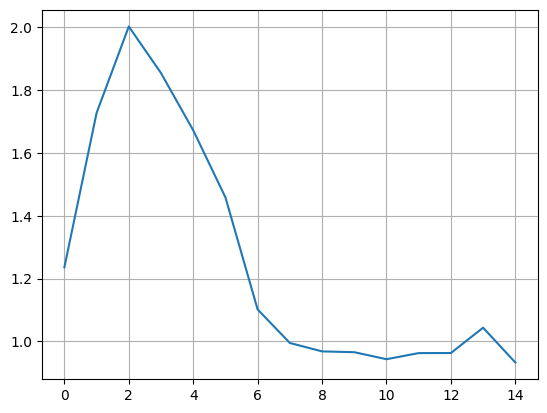

In [83]:
plt.plot(history)
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 28ms/step


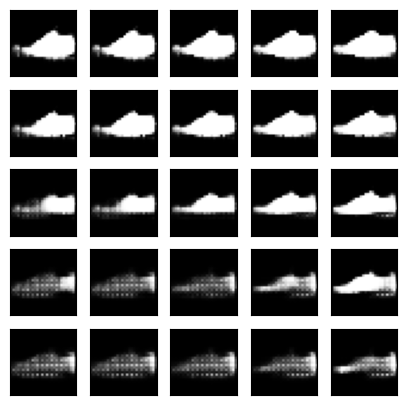

In [84]:
# отображение результатов генерации
n = 2
total = 2 * n + 1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n + 1):
  for j in range(-n, n + 1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = generator.predict(np.expand_dims([0.5 * i / n, 0.5 * j / n], axis=0))
    plt.imshow(img[0, :, :, 0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
x_test[0]

In [ ]:
y_test[0]

In [26]:
generator.predict(x_test[0])

ValueError: ignored